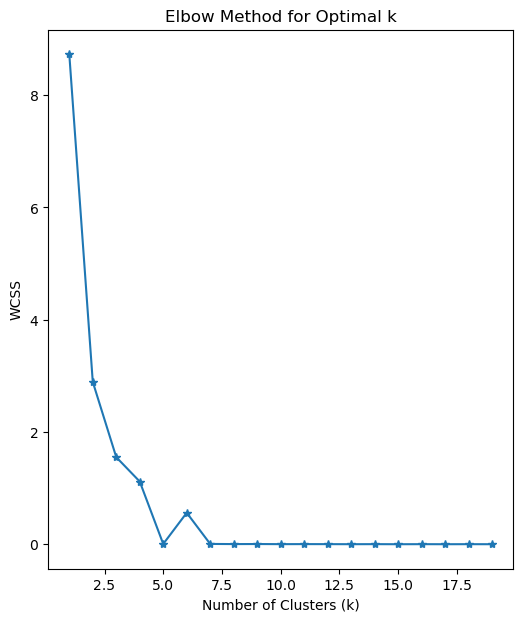

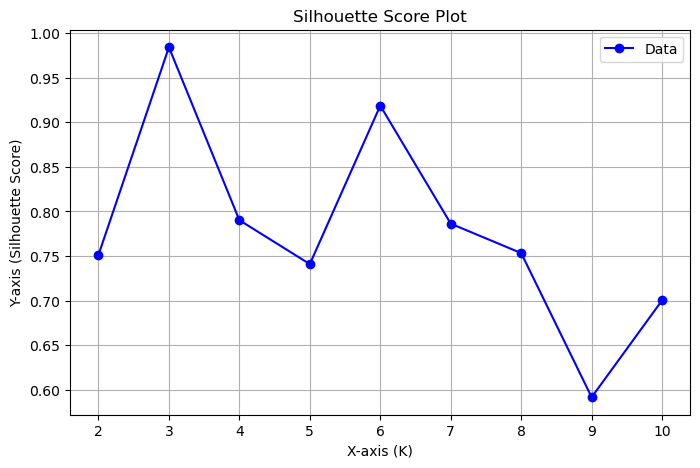

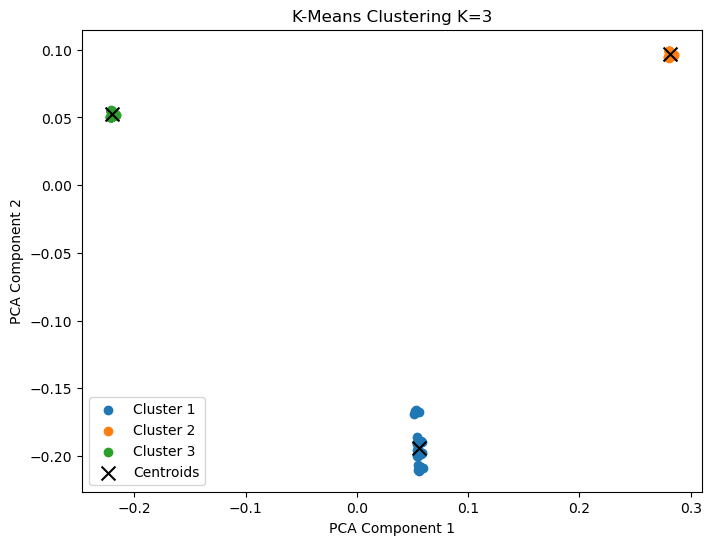

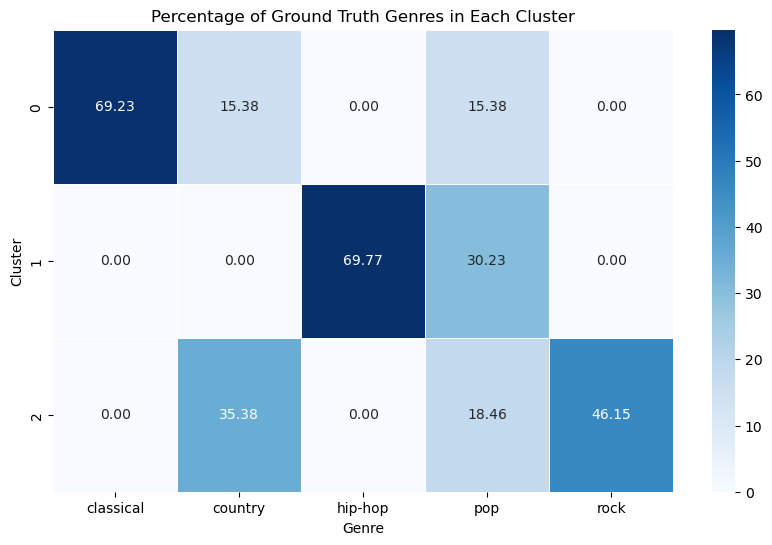

Clustering complete! CSV file saved.
Clustering Accuracy: 59.18%
Keywords: ['piano', 'calm', 'slow'] -> Predicted Genre: Classical
Keywords: ['guitar', 'emotional', 'distorted'] -> Predicted Genre: Classical
Keywords: ['synth', 'mellow', 'distorted'] -> Predicted Genre: Classical


In [61]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math
import random

#n=random.randint(1,100)
#print(n)
np.random.seed(160)

def cdist(X, C):
    # Compute squared differences, sum across features, then take sqrt
    distances = np.sqrt(((X[:, np.newaxis] - C) ** 2).sum(axis=2))
    return distances

# Function to compute cosine similarity manually
def cosine_similarity(A, B):
    A_norm = np.linalg.norm(A, axis=1, keepdims=True)
    B_norm = np.linalg.norm(B, axis=1, keepdims=True)
    
    A_norm[A_norm == 0] = 1  # Prevent division by zero
    B_norm[B_norm == 0] = 1  
    
    return (A @ B.T) / (A_norm @ B_norm.T)
    
def silhouette_score(X, labels):
    unique_clusters = np.unique(labels)
    silhouette_scores = np.zeros(X.shape[0])

    for i, x in enumerate(X):
        cluster = labels[i]
        
        # Compute a(i): Intra-cluster distance
        same_cluster_points = X[labels == cluster]
        a_i = np.mean(np.linalg.norm(same_cluster_points - x, axis=1)) if len(same_cluster_points) > 1 else 0

        # Compute b(i): Nearest-cluster distance
        b_i = float('inf')
        for other_cluster in unique_clusters:
            if other_cluster == cluster:
                continue
            other_cluster_points = X[labels == other_cluster]
            mean_distance = np.mean(np.linalg.norm(other_cluster_points - x, axis=1))
            b_i = min(b_i, mean_distance)

        # Compute silhouette score for point i
        silhouette_scores[i] = (b_i - a_i) / max(a_i, b_i) if max(a_i, b_i) != 0 else 0

    return np.mean(silhouette_scores)  # Average silhouette score for all points
    
def kmeans(X, k, max_iters=100):
    """Perform K-Means clustering manually."""
    n_samples = X.shape[0]
    centroids = X[np.random.choice(n_samples, k, replace=False)]  # Random init

    for _ in range(max_iters):
        # Compute distances and assign clusters
        distances = cdist(X, centroids)
        labels = np.argmin(distances, axis=1)
        
        # Compute new centroids
        new_centroids = []
        for j in range(k):
            cluster_points = X[labels == j]  # Select points belonging to cluster j
            if len(cluster_points) > 0:  # Only update if cluster has points
                new_centroids.append(cluster_points.mean(axis=0))
            else:
            # If a cluster is empty, reinitialize it to a random data point
                new_centroids.append(X[np.random.randint(0, X.shape[0])])

        new_centroids = np.array(new_centroids)
        
        # Check convergence
        if np.allclose(centroids, new_centroids, atol=1e-4):
            break
        centroids = new_centroids
    
    return labels, centroids

def compute_wcss(X, k_range):
    """Calculate WCSS for different values of k."""
    wcss = []
    for k in k_range:
        labels, centroids = kmeans(X, k)
        wcss.append(sum(np.min(cdist(X, centroids), axis=1)**2))
    return wcss

################################################################################################
#                                   VECTORIZATION                                              #
################################################################################################
# Load dataset
file_path = "TASK2_dataset.csv"
df = pd.read_csv(file_path)

# Extract keyword columns
keywords_1 = df["keyword_1"].tolist()
keywords_2 = df["keyword_2"].tolist()
keywords_3 = df["keyword_3"].tolist()

# Combine all keywords to build vocabulary
all_keywords = keywords_1 + keywords_2 + keywords_3
vocab = set(all_keywords)

# Number of documents (songs)
num_songs = len(df)

#computing TF for each keyword
tf={}
for word in vocab :
    if word in keywords_1:
        tf[word]=keywords_1.count(word)/len(keywords_1)
    if word in keywords_2:
        tf[word]=keywords_2.count(word)/len(keywords_2)
    if word in keywords_3:
        tf[word]=keywords_3.count(word)/len(keywords_3)
# Compute IDF for each word
idf = {}
for word in vocab:
    doc_count = sum(1 for song in df.itertuples() if word in [song.keyword_1, song.keyword_2, song.keyword_3])
    idf[word] = math.log(num_songs / doc_count)

# Compute TF-IDF for each keyword position separately
tfidf_vector_1 = [{word: tf[word]*idf[word] for word in [kw]} for kw in keywords_1]
tfidf_vector_2 = [{word: tf[word]*idf[word] for word in [kw]} for kw in keywords_2]
tfidf_vector_3 = [{word: tf[word]*idf[word] for word in [kw]} for kw in keywords_3]

# Convert to DataFrame
tfidf_df_1 = pd.DataFrame(tfidf_vector_1).fillna(0)
tfidf_df_2 = pd.DataFrame(tfidf_vector_2).fillna(0)
tfidf_df_3 = pd.DataFrame(tfidf_vector_3).fillna(0)

#print(tfidf_df_1)
#print(tfidf_df_2)
#print(tfidf_df_3)
"""print("TF-IDF for Keyword 1:")
print(tfidf_df_1.head())

print("\nTF-IDF for Keyword 2:")
print(tfidf_df_2.head())

print("\nTF-IDF for Keyword 3:")
print(tfidf_df_3.head())"""


################################################################################################
#                       DIMENSIONALITY REDUCTION                                               #
################################################################################################
tfidf_df_main=[tfidf_df_1,tfidf_df_2,tfidf_df_3]

pca_results = []  # List to store PCA results for each TF-IDF vector

for tfidf_df in tfidf_df_main:
    # Step 1: Standardize the data (subtract mean)
    tfidf_matrix = tfidf_df.to_numpy()
    mean_vec = np.mean(tfidf_matrix, axis=0)
    std_data = tfidf_matrix - mean_vec

    # Step 2: Compute Covariance Matrix
    cov_matrix = np.cov(std_data, rowvar=False)

    # Step 3: Compute Eigenvalues and Eigenvectors
    eigenvalues, eigenvectors = np.linalg.eig(cov_matrix)

    # Step 4: Sort Eigenvectors by Eigenvalues (Descending Order)
    sorted_indices = np.argsort(eigenvalues)[::-1]
    eigenvectors = eigenvectors[:, sorted_indices]

    # Step 5: Reduce Dimensions (Keep First 2 Principal Components)
    num_components = 2
    top_eigenvectors = eigenvectors[:, :num_components]

    # Step 6: Project Data onto New Space
    pca_transformed_data = np.dot(std_data, top_eigenvectors)
    pca_transformed_df = pd.DataFrame(pca_transformed_data, columns=['PC1', 'PC2'])

    # Store result
    pca_results.append(pca_transformed_df)

# pca_results now contains three 2D transformed vectors
# Define weights for each PCA vector (Adjust as needed)
################################################################################################
#                       COMBINING EMBEDDINGS                                                   #
################################################################################################
weights = np.array([100, 1, 0.2])  # Example: First PCA result has higher importance

# Ensure weights sum to 1 (Normalize if necessary)
weights = weights / np.sum(weights)

# Stack the PCA results to create a 3D array (N samples × 3 PCA results × 2D features)
stacked_pca = np.stack([pca_results[i].to_numpy() for i in range(3)], axis=2)  # Shape: (N, 2, 3)

# Apply weighted mean along the last axis (combining three vectors)
combined_embedding = np.tensordot(stacked_pca, weights, axes=(2, 0))  # Shape: (N, 2)

# Convert back to DataFrame
combined_embedding_df = pd.DataFrame(combined_embedding, columns=['Combined_PC1', 'Combined_PC2'])

#print(combined_embedding_df.head())  # Display the final embedding

    #combined_embedding = np.concatenate((pca1, pca2), axis=1)
    #pca_df = pd.DataFrame(pca_transformed_data, columns=[f"PC{i+1}" for i in range(num_components)])
    #print(combined_embedding)
    #print(pc1)
    #print(pc2)
    #print(combined_embedding2)

################################################################################################
#                       CLUSTER ANALYSIS                                                       #
################################################################################################
#X = combined_embedding.to_numpy()
# Try different k values
k_range = range(1, 20)
#wcss = compute_wcss(combined_embedding, k_range)
num_runs = 10
wcss_list = []
for _ in range(num_runs):
    wcss = compute_wcss(combined_embedding, k_range)  # Your WCSS function
    wcss_list.append(wcss)

wcss = np.mean(wcss_list, axis=0)
# Plot the Elbow Curve
plt.figure(figsize=(6, 7))
plt.plot(k_range, wcss, marker='*', linestyle='-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('WCSS')
plt.title('Elbow Method for Optimal k')
plt.show()
#print(pca_df.head())
# Set k (choose optimal from elbow method)
#Optimal k can be 3, 4 and 5
sill_score=[]
for optimal_k in range(2,11):
    labels, centroids = kmeans(combined_embedding, optimal_k)

    '''# Plot clusters
    plt.figure(figsize=(8, 6))
    for i in range(optimal_k):
        plt.scatter(combined_embedding[labels == i, 0], combined_embedding[labels == i, 1], label=f'Cluster {i+1}')

    # Plot centroids
    plt.scatter(centroids[:, 0], centroids[:, 1], c='black', marker='x', s=100, label='Centroids')

    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.legend()
    plt.title(f'K-Means Clustering K={optimal_k}')
    plt.show()'''
    silhouette_avg = silhouette_score(combined_embedding, labels)
    sill_score.append(silhouette_avg)
    
x_values = list(range(2,11))    # X-axis (keys)
y_values = list(sill_score)  # Y-axis (values)

curr=0
i=0
ans=x_values[0]
for y in y_values:
    if(y>curr):
        ans=x_values[0]+i
        curr=y
    i+=1
        
# Plot the dictionary
plt.figure(figsize=(8,5))
plt.plot(x_values, y_values, marker='o', linestyle='-', color='b', label="Data")

# Labels and title
plt.xlabel("X-axis (K)")
plt.ylabel("Y-axis (Silhouette Score)")
plt.title("Silhouette Score Plot")

plt.legend()
plt.grid(True)
plt.show()

optimal_k=ans
labels, centroids = kmeans(combined_embedding, optimal_k)

    # Plot clusters
plt.figure(figsize=(8, 6))
for i in range(optimal_k):
    plt.scatter(combined_embedding[labels == i, 0], combined_embedding[labels == i, 1], label=f'Cluster {i+1}')

    # Plot centroids
plt.scatter(centroids[:, 0], centroids[:, 1], c='black', marker='x', s=100, label='Centroids')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend()
plt.title(f'K-Means Clustering K={optimal_k}')
plt.show()

df['Clusters']=labels
#df.to_csv("song_clusters.csv", index=False)

# Step 1: Create a mapping from Cluster → Majority Genre
mapping = {}
for cluster in df["Clusters"].unique():
    most_frequent_genre = df[df["Clusters"] == cluster]["genre"].mode()[0]  # Find most common genre in cluster
    mapping[cluster] = most_frequent_genre  # Assign mapping



# Step 1: Compute Genre Distribution per Cluster
cluster_genre_counts = df.groupby("Clusters")["genre"].value_counts(normalize=True) * 100
cluster_genre_df = cluster_genre_counts.unstack().fillna(0)  # Convert to DataFrame

# Step 2: Plot Heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(cluster_genre_df, annot=True, fmt=".2f", cmap="Blues", linewidths=0.5)

# Step 3: Labels and Titles
plt.xlabel("Genre")
plt.ylabel("Cluster")
plt.title("Percentage of Ground Truth Genres in Each Cluster")

# Show the Plot
plt.show()


df["Predicted_Genre"] = df["Clusters"].map(mapping)

# Step 3: Compute Accuracy
accuracy = np.mean(df["Predicted_Genre"] == df["genre"]) * 100
df.to_csv("song_clusters.csv", index=False)
print("Clustering complete! CSV file saved.")
# Print Results
print(f"Clustering Accuracy: {accuracy:.2f}%")


################################################################                                      
#                          ASSIGNING GENRE                     #
################################################################
# Load the precomputed TF-IDF DataFrame and genre mappings
song_clusters = pd.read_csv("song_clusters.csv")

# Convert the DataFrame into a dictionary of DataFrames, assuming 'cluster' column represents cluster indices
tfidf_df_main = {
    cluster: df.drop(columns=['Clusters']).apply(pd.to_numeric, errors='coerce').fillna(0) 
    for cluster, df in song_clusters.groupby('Clusters')
}

# Assuming 'tfidf_df_main' is a dictionary with keys as cluster indices and values as DataFrames
cluster_genre_map = {
    0: "Classical",
    1: "Hip-Hop",
    2: "Rock",
    3: "Rock",
    4: "Country",
    5: "pop"
}
# Define new song keywords
new_songs = [
    ["piano", "calm", "slow"],
    ["guitar", "emotional", "distorted"],
    ["synth", "mellow", "distorted"]
]

# Extract the common vocabulary from the main TF-IDF dataframe
idf = {}
for df in tfidf_df_main.values():  # Iterate over DataFrames
    for word in df.columns:
        idf[word] = idf.get(word, 0) + 1  # Presence-based IDF-like weight

common_vocab = list(idf.keys())

# Convert new song keywords to TF-IDF-like vectors
new_tfidf_vectors = np.array([
    [idf.get(word, 0) if word in common_vocab else 0 for word in common_vocab]
    for song in new_songs
], dtype=np.float64)  # Ensure float64 type

# Avoid division by zero when normalizing
norms = np.linalg.norm(new_tfidf_vectors, axis=1, keepdims=True)
norms[norms == 0] = 1  # Prevent division by zero
new_tfidf_vectors /= norms

# Compute cluster centroids, handling empty clusters
cluster_centroids = []
for df in tfidf_df_main.values():
    if df.shape[0] > 0:
        cluster_centroids.append(np.mean(df.to_numpy(), axis=0))
    else:
        cluster_centroids.append(np.zeros(len(common_vocab)))  # Placeholder for empty clusters

cluster_centroids = np.array(cluster_centroids)

# Compute cosine similarity with existing cluster centroids
similarities = cosine_similarity(new_tfidf_vectors, cluster_centroids)

# Assign each new song to the closest cluster
assigned_genres = [cluster_genre_map.get(np.argmax(sim), "Unknown") for sim in similarities]

# Print results
for i, song in enumerate(new_songs):
    print(f"Keywords: {song} -> Predicted Genre: {assigned_genres[i]}")


In [62]:
import numpy as np
import pandas as pd
from collections import Counter

# Function to calculate Purity Score
def purity_score(true_labels, cluster_labels):
    cluster_purity = []
    for cluster in set(cluster_labels):
        indices = np.where(cluster_labels == cluster)[0]
        true_classes = true_labels[indices]
        most_common = Counter(true_classes).most_common(1)[0][1]
        cluster_purity.append(most_common / len(indices))
    return np.mean(cluster_purity)

# Function to calculate Normalized Mutual Information (NMI)
def entropy(labels):
    counts = np.bincount(labels)
    probs = counts / len(labels)
    return -np.sum(probs * np.log2(probs + 1e-9))

def mutual_information(true_labels, cluster_labels):
    joint_counts = Counter(zip(true_labels, cluster_labels))
    total_samples = len(true_labels)
    mutual_info = 0
    
    for (true_label, cluster), count in joint_counts.items():
        p_xy = count / total_samples
        p_x = np.sum(true_labels == true_label) / total_samples
        p_y = np.sum(cluster_labels == cluster) / total_samples
        mutual_info += p_xy * np.log2(p_xy / (p_x * p_y) + 1e-9)
    
    return mutual_info

def normalized_mutual_info(true_labels, cluster_labels):
    mi = mutual_information(true_labels, cluster_labels)
    h_true = entropy(true_labels)
    h_cluster = entropy(cluster_labels)
    return 2 * mi / (h_true + h_cluster)

# Function to calculate Adjusted Rand Index (ARI)
def adjusted_rand_index(true_labels, cluster_labels):
    from scipy.special import comb
    
    contingency_matrix = np.zeros((len(set(true_labels)), len(set(cluster_labels))))
    for i, j in zip(true_labels, cluster_labels):
        contingency_matrix[i, j] += 1
    
    sum_comb = np.sum(comb(contingency_matrix, 2))
    row_comb = np.sum(comb(np.sum(contingency_matrix, axis=1), 2))
    col_comb = np.sum(comb(np.sum(contingency_matrix, axis=0), 2))
    total_comb = comb(len(true_labels), 2)
    
    expected_index = (row_comb * col_comb) / total_comb
    max_index = (row_comb + col_comb) / 2
    
    return (sum_comb - expected_index) / (max_index - expected_index)

# Function to calculate Fowlkes-Mallows Index (FMI)
def fowlkes_mallows_index(true_labels, cluster_labels):
    from scipy.special import comb
    
    contingency_matrix = np.zeros((len(set(true_labels)), len(set(cluster_labels))))
    for i, j in zip(true_labels, cluster_labels):
        contingency_matrix[i, j] += 1
    
    tp = np.sum(comb(contingency_matrix, 2))
    fp = np.sum(comb(np.sum(contingency_matrix, axis=1), 2)) - tp
    fn = np.sum(comb(np.sum(contingency_matrix, axis=0), 2)) - tp
    
    return np.sqrt((tp / (tp + fp)) * (tp / (tp + fn)))

# Load the precomputed TF-IDF DataFrame and genre mappings
song_clusters = pd.read_csv("song_clusters.csv")
true_labels = song_clusters['genre'].astype('category').cat.codes.to_numpy()
cluster_labels = song_clusters['Clusters'].to_numpy()

# Compute extrinsic clustering metrics
purity = purity_score(true_labels, cluster_labels)
nmi = normalized_mutual_info(true_labels, cluster_labels)
ari = adjusted_rand_index(true_labels, cluster_labels)
fmi = fowlkes_mallows_index(true_labels, cluster_labels)

# Print results
print(f"Purity Score: {purity:.4f}")
print(f"Normalized Mutual Information (NMI): {nmi:.4f}")
print(f"Adjusted Rand Index (ARI): {ari:.4f}")
print(f"Fowlkes-Mallows Index (FMI): {fmi:.4f}")


Purity Score: 0.6172
Normalized Mutual Information (NMI): 0.5599
Adjusted Rand Index (ARI): 0.4226
Fowlkes-Mallows Index (FMI): 0.5904
